<a href="https://colab.research.google.com/github/Sobiii/Search-Engine-Design-G4/blob/Sobii/Sobs_Attempt5_Elastic_Search_loaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Documents

## CISI ALL extraction

In [1]:
import os as os

# get the current working directory
notebook_dir = os.getcwd()

# define paths to CISI dataset files
cisi_all_path = os.path.join(notebook_dir, 'CISI.ALL')
cisi_qry_path = os.path.join(notebook_dir, 'CISI.QRY')
cisi_rel_path = os.path.join(notebook_dir, 'CISI.REL')

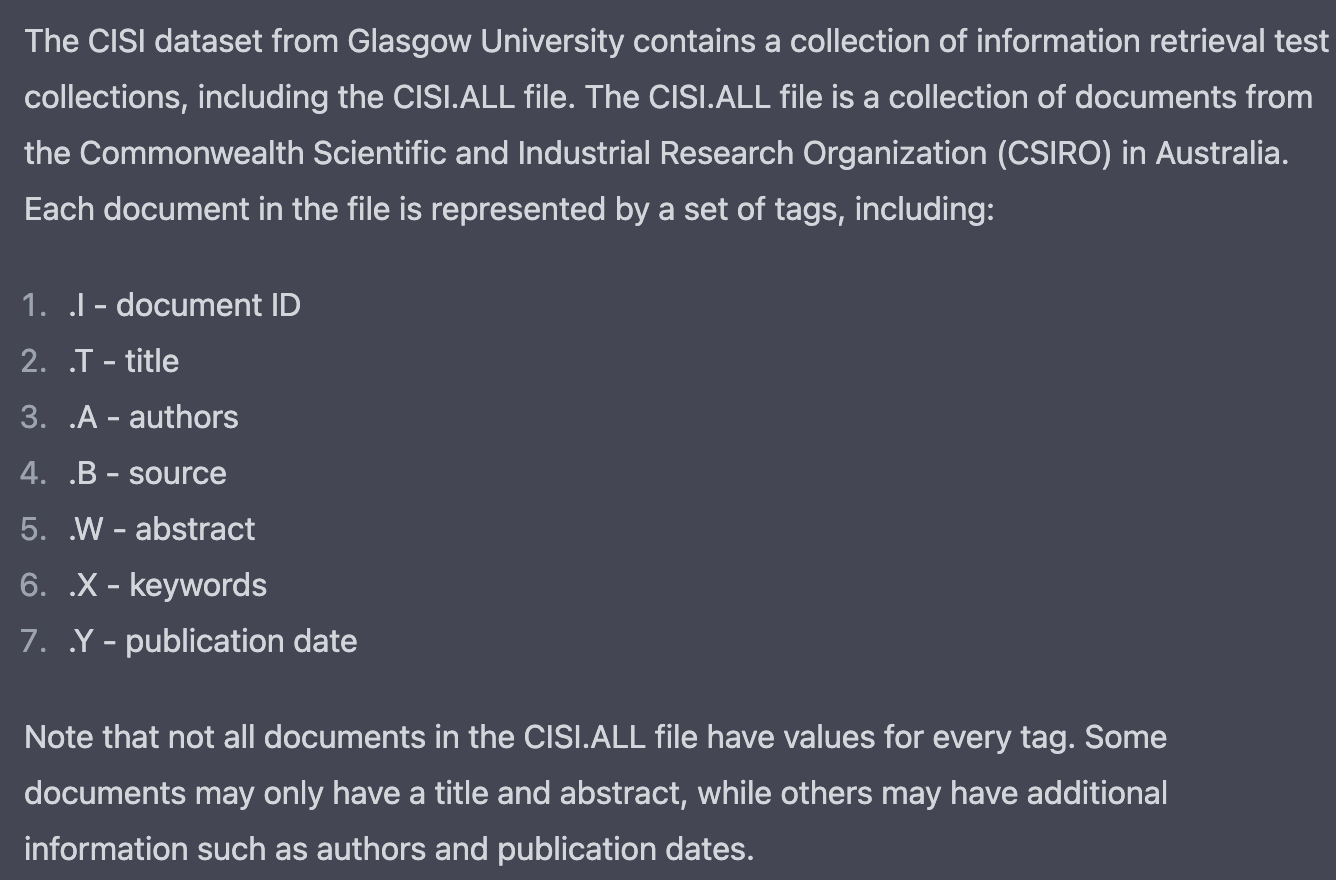

In [2]:
import re

def extraction(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    doc_ids = []
    documents = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            doc_id = file_lines[i].split()[1]
            doc_ids.append(doc_id)
            if file_lines[i+1].startswith(".T") and file_lines[i+3].startswith(".A"):
                title = file_lines[i+2][:].strip()
            else:
                title = file_lines[i+2].strip() + " " + file_lines[i+3].strip()
            authors = ""
            if any([line.startswith(".A") for line in file_lines[i+1:]]):
                author_start = i+4
                author_end = author_start
                while author_end < len(file_lines) and not any([file_lines[author_end].startswith(tag) for tag in [".T", ".B", ".W", ".Y"]]):
                    author_end += 1
                authors = " ".join([file_lines[j].strip() for j in range(author_start, author_end)]).strip()
                authors = re.sub(r"^\s*\.\s*A\s*", "", authors)
                abstract_start = author_end
            else:
                abstract_start = i+4

            for t in range(i+4, len(file_lines)):
                if file_lines[t].startswith(".X"):
                    abstract_end = t
                    break
            else:
                abstract_end = len(file_lines)
            abstract = " ".join(file_lines[abstract_start:abstract_end]).strip().replace('\n', ' ')
            abstract = re.sub(r"^\s*\.\s*W\s*", "", abstract)
            abstract = " ".join(abstract.split())
            source = re.search(r"\.B\s+(.*)\.W", abstract)
            if source:
                source = source.group(1)
                source = re.sub(r"^\s*\.\s*A\s*", "", source)
                source = re.sub(r"^\s*\.\s*B\s*", "", source)
            else:
                source = ""
            abstract = re.sub(r"^\s*\.\s*B\s*(.*)\.W", "", abstract)
            abstract = " ".join(abstract.split())
            year = re.search(r"\.Y\s+(\d{4})", abstract)
            if year:
                year = int(year.group(1))
            else:
                year = ""
            abstract = re.sub(r"^\s*\.\s*Y\s*\d{4}\s*", "", abstract)
            abstract = " ".join(abstract.split())
            documents.append({"document_id": doc_id, "title": title, "authors": authors, "abstract": abstract, "source": source, "year": year})
            i = abstract_end
        else:
            i += 1

    return documents


In [ ]:
documents = extraction(cisi_all_path)
documents

## CISI QRY extraction

The following code is correct and works for the first 57 queries (1-57) how wever the remaining queiries have a different format and thus different code to extract those.

## Extraction of 1st 57 Queries from CISI.QRY

In [4]:
# query extraction from CISI.QRY file (1st 57 queries only)
def extraction_query(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries_1 = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                break
            if file_lines[i+1].startswith(".W"):
                query_text = file_lines[i+2].strip()
                for t in range(i+3, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    query_text += " " + file_lines[t].strip()
            else:
                query_text = ""
            queries_1.append({"query_id": query_id, "query_text": query_text})
        i += 1

    return queries_1

In [ ]:
queries_1 = extraction_query(cisi_qry_path)
queries_1

## Extraction of remaining Queries from CISI.QRY

In [6]:
# query extraction from CISI.QRY file (58th query onwards)
def extraction_remaining_queries(file_name_path):
    with open(file_name_path) as f:
        file_lines = f.readlines()

    queries = []
    i = 0
    while i < len(file_lines):
        if file_lines[i].startswith(".I"):
            query_id = int(file_lines[i][3:])
            if query_id > 57:
                query_title = ""
                query_author = ""
                query_text = ""
                query_source = ""
                found_text_field = False
                found_source_field = False
                for t in range(i+1, len(file_lines)):
                    if file_lines[t].startswith(".I"):
                        break
                    elif file_lines[t].startswith(".T"):
                        query_title += file_lines[t][3:].strip()
                        # Check if the next line starts with .A and the line after that starts with .T
                        next_t = t+1
                        if next_t < len(file_lines) and file_lines[next_t].startswith(".A") and (next_t+1) < len(file_lines) and file_lines[next_t+1].startswith(".T"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                        # Check if the next line also contains title text
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".A") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B"):
                            query_title += " " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".A"):
                        query_author += file_lines[t+1][3:].strip()
                        # Check if the next line also contains author text
                        next_t = t+1
                        while next_t < len(file_lines) and not file_lines[next_t].startswith(".I") and not file_lines[next_t].startswith(".T") and not file_lines[next_t].startswith(".W") and not file_lines[next_t].startswith(".B") and not file_lines[next_t].startswith(".A"):
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                            query_author += ", " + file_lines[next_t].strip()
                            next_t += 1
                    elif file_lines[t].startswith(".W"):
                        found_text_field = True
                        query_text = re.sub(r'^\.W\s*', '', file_lines[t].strip())  # Use regex to remove ".W" tag from the beginning of the line
                        for u in range(t+2, len(file_lines)):
                            if file_lines[u].startswith(".I") or file_lines[u].startswith(".B"):
                                break
                            query_text += " " + file_lines[u].strip()
                    elif file_lines[t].startswith(".B"):
                        found_source_field = True
                        query_source = file_lines[t][3:].strip()
                        for u in range(t+1, len(file_lines)):
                            if file_lines[u].startswith(".I"):
                                break
                            query_source += " " + file_lines[u].strip()
                    elif not found_text_field and not found_source_field:
                        # Assume any field that appears before the .W and .B field is either the title or author
                        if not query_title:
                            query_title = file_lines[t].strip()
                        elif query_author:
                            query_author = file_lines[t-1].strip()
                            query_author += file_lines[t].strip()
                queries.append({"query_id": query_id, "query_title": query_title, "query_author": query_author, "query_text": query_text, "query_source": query_source})
        i += 1

    return queries

In [ ]:
queries_2 = extraction_remaining_queries(cisi_qry_path)
queries_2

## Merging both queury sets together as queries_all


In [ ]:
# Merged Queries 
queries_all = queries_1 + queries_2
#print(queries_all)

# Pre-processing CISI Data 


The following NLP preprocessing steps will be administered to both the document and query data:

1.   Tokenizing
2.   Converting text to lowercase
3.   Removing stopwords
4.   Removing special characters, numbers, and punctuation marks

### Preprocessing the Document data and producing the Corpus

In [9]:
# Importing NLP preprocessing libraries
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Creating corpus
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

documents = extraction(cisi_all_path)
corpus = []

for document in documents:
    text = ""
    if "title" in document and document["title"]:
        text += document["title"]
    if "authors" in document and document["authors"]:
        text += " " + document["authors"]
    if "abstract" in document and document["abstract"]:
        text += " " + document["abstract"]
    if text:  # only add non-empty strings to corpus
        # Remove special characters, numbers, and punctuation marks
        text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
        # Remove quotation marks
        text = text.replace("'", "").replace('"', '')
        # Tokenize and convert to lowercase
        tokens = word_tokenize(text.lower())
        # Remove stop words
        filtered_text = [word for word in tokens if word not in stop_words]
        # Lemmatize words
        lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
        # Join tokens back to form a string
        preprocessed_text = ' '.join(lemmatized_text)
        corpus.append(preprocessed_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Printing the 3rd document from corpus to check against CISI.ALL file
print(corpus[2])

two kind power essay bibliographic control wilson p relationship organization control writing organization control knowledge information inevitably enter story writing contain along much else great deal mankind stock knowledge information bibliographical control form power knowledge form power familiar slogan claim bibliographical control certain sense power power power obtain knowledge recorded written form writing simply simple way storehouse knowledge satisfactorily discus bibliographical control simply control knowledge information contained writing


### Prepreocessing Queries terms

In [11]:
# Preprocessing queries
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_queries_all = []

for query in queries_all:
    query_text = query['query_text']  # Extract query_text from the dictionary
    # Tokenize and convert to lowercase
    tokens = word_tokenize(query_text.lower())
    # Remove special characters, numbers, and punctuation marks
    filtered_query = [word for word in tokens if word not in string.punctuation + string.digits]
    # Remove quotation marks
    filtered_query = [word.replace("'", "").replace('"', '') for word in filtered_query]
    # Remove stop words
    filtered_query = [word for word in filtered_query if word not in stop_words]
    # Lemmatize words
    lemmatized_query = [lemmatizer.lemmatize(word) for word in filtered_query]
    # Join tokens back to form a string
    preprocessed_query = ' '.join(lemmatized_query)
    preprocessed_queries_all.append(preprocessed_query)
    qry_terms_all = preprocessed_queries_all

In [12]:
# Printing example queries
qry_terms_all[58]

'ability direct user selectively text material whose identity location known method requires human searcher base searching strategy actual passage book rather test query natural contrived circumvents need relevance judgement still yield performance indicator correspond approximately recall precision ratio large document retrieval system evaluation preliminary application method subject indexing two major encyclopedia showed one encyclopedia apparently superior finding discrimination ability retrieval performance method presently best suited comparative testing since ability yield absolute reproducible measure yet established'

# Indexing 

manual - only did what was necessary for BM25


## Indexing CISI documents

In [13]:
# Indexing using count vectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
documents_vectorized = vectorizer.fit_transform(corpus)
print ('We have a {} document corpus with a {} term vocabulary'.format(*documents_vectorized.shape))

We have a 1460 document corpus with a 10290 term vocabulary


In [14]:
# Creating a document term-frequency matrix
import pandas as pd

vocabulary = vectorizer.get_feature_names_out()
df = pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)
doc_ids = df.index.values
df.head() # Note empty just sparse

,aa,aacr,aacrthere,ab,abandon,abandonment,abbot,abbreviated,abbreviating,abbreviation,...,zipfian,zipfs,zipperer,zone,zoology,zuckerman,zuckermans,zunde,zvezhinskii,zyabrev
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Indexing Query terms

In [15]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Use the vectorizer to transform the list of query terms into a term-document matrix
qry_terms_all_matrix = vectorizer.fit_transform(qry_terms_all)

# Convert the sparse matrix to a dense matrix
qry_terms_all_dense = qry_terms_all_matrix.toarray()

# Create a DataFrame from the dense matrix
qry_terms_all_df = pd.DataFrame(qry_terms_all_dense, columns=vectorizer.get_feature_names_out())
qry_terms_all_df.head() # sparse dataframe

,000,10,100,11,121,13,148,1712,177,1960s,...,working,worth,would,write,writer,written,year,yet,yield,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Chacking dataframe
non_zero_values = qry_terms_all_df[qry_terms_all_df != 0].stack().dropna().reset_index()
non_zero_values.columns = ['Row', 'Column', 'Value']
print(non_zero_values)

      Row         Column  Value
0       0    approximate    1.0
1       0        article    2.0
2       0  automatically    1.0
3       0        concern    1.0
4       0        content    1.0
...   ...            ...    ...
3599  111           time    1.0
3600  111       together    1.0
3601  111          using    1.0
3602  111         valued    1.0
3603  111           zero    1.0

[3604 rows x 3 columns]


## Importing Elasticsearch

In [17]:
# Need to figure this out. Doesnt work.

In [55]:
# Dowloading elasticSearch
!wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
!wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
!tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
!sudo chown -R daemon:daemon elasticsearch-7.9.2/
!shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 
!pip install elasticsearch==7.9.1 -q
!pip freeze | grep elasticsearch

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 KB 7.0 MB/s eta 0:00:00
elasticsearch==7.9.1


In [56]:
# Importing ES
from elasticsearch import Elasticsearch

In [57]:
%%bash --bg
sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

In [58]:
%%bash
ps -ef | grep elasticsearch

root       38525   38523  0 12:41 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon     38526   38525  0 12:41 ?        00:00:00 /bin/bash elasticsearch-7.9.2/bin/elasticsearch
daemon     38679   38526  0 12:41 ?        00:00:00 /bin/bash elasticsearch-7.9.2/bin/elasticsearch
daemon     38680   38679  0 12:41 ?        00:00:00 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -cp /content/elasticsearch-7.9.2/lib/* org.elasticsearch.tools.launchers.JvmOptionsParser /content/elasticsearch-7.9.2/config
root       38697   38693  0 12:41 ?        00:00:00 grep elasticsearch


In [60]:
# starting es server
import time
time.sleep(20) # give the server 20 seconds to start
!curl -X GET "http://localhost:9200"

{
  "name" : "e68f756d57d0",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "sGkd069oQECC2vvZwizhNA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [61]:
es = Elasticsearch("http://localhost:9200")

# Let's test whether we have succesfully started an ES instance and
# imported the python library
if es.ping():
  print('ES instance working')
else:
  print('ES instance not working')

ES instance working


In [62]:
# Server information
es.info()

{'name': 'e68f756d57d0',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'sGkd069oQECC2vvZwizhNA',
 'version': {'number': '7.9.2',
  'build_flavor': 'oss',
  'build_type': 'tar',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

# BM25 Implementation

The following fucntion calculates BM25 scores and outputs a pandas dataframe containing the scores with matching index and column names. It takes values for paramaters such as df and k1, k2, k3, b and term_weights that can be used to finetune the BM25 model.

In [18]:
# BM25 Implementation
import numpy as np


def calculate_bm25_score(df, k1, k2, k3, b, term_weights):
    
    # Calculate DF
    dfs = (df > 0).sum(axis=0)
    
    # Calculate IDFs
    N = len(df)
    idfs = np.log10(N/dfs)
    
    # Calculate average document length
    dls = df.sum(axis=1).tolist()
    avgdl = np.mean(dls)
    
    # Calculate BM25 score
    numerator = np.array((k1 + 1) * df)
    denominator = np.array(k1 * ((1 - b) + b * (dls / avgdl))).reshape(N, 1) + np.array(df)
    BM25_tf = numerator / denominator
    idfs = np.array(idfs)
    BM25_score = (idfs * BM25_tf * term_weights) + ((k2 + 1) * term_weights * df) / ((k2 * (1 - b + b * (dls / avgdl))).reshape(N, 1) + df) + (k3 * term_weights)
    
    # Convert BM25 score to a pandas DataFrame with matching index and column names
    BM25_score = pd.DataFrame(BM25_score, columns=df.columns, index=df.index)
    
    return BM25_score


### Creating a dataframe of BM25 scores

In [19]:
# Instance of BM25 for CISI documents
bm25_scores = calculate_bm25_score(df, k1=0.7, k2=1.5, k3=1, b=0.8, term_weights=1)
bm25_scores.head() #  not empty just sparse

,aa,aacr,aacrthere,ab,abandon,abandonment,abbot,abbreviated,abbreviating,abbreviation,...,zipfian,zipfs,zipperer,zone,zoology,zuckerman,zuckermans,zunde,zvezhinskii,zyabrev
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
# code used to check that the bm25_scores df is correct
non_zero_values = df[df != 0].stack().dropna().reset_index()
non_zero_values.columns = ['Row', 'Column', 'Value']
print(non_zero_values)

        Row      Column  Value
0         0      abroad    1.0
1         0      appear    1.0
2         0     attempt    1.0
3         0   biography    1.0
4         0     briefly    1.0
...     ...         ...    ...
74372  1459  technology    2.0
74373  1459    thousand    1.0
74374  1459        time    1.0
74375  1459       world    2.0
74376  1459        year    3.0

[74377 rows x 3 columns]


###Creating a copy of the BM25_scores df that only contains qry_terms_1

In [21]:
# Creating a copy of the BM25_scores df based on the values in qry_terms_all_df
qry_all_BM25 = bm25_scores
columns_to_drop = list(set(bm25_scores.columns) - set(qry_terms_all_df.columns))

# Drop columns from qry_all_BM25
qry_all_BM25 = qry_all_BM25.drop(columns=columns_to_drop)
qry_all_BM25.head()

,ability,able,absolute,abstract,accepted,access,according,accurate,accurately,achieving,...,work,worker,working,worth,write,writer,written,year,yield,zero
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.167619,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,3.537108,1.000000,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,2.698332,1.0,1.0


### Calculating the total BM25 scores per document based on queries

In [22]:
# Calculating the total BM25 scores per document based on qry terms only
score_q = qry_all_BM25.sum(axis=1)
score_q 

0       1294.397449
1       1311.502038
2       1315.665497
3       1317.034336
4       1347.634755
           ...     
1455    1318.049166
1456    1326.139314
1457    1300.333021
1458    1305.015106
1459    1313.643024
Length: 1460, dtype: float64

## Ranking documents based on BM25 for the queries

In [ ]:
# rank the documents based on the queries
BM_ranked_docs_q = sorted(zip(enumerate(documents), score_q .values),
                     key = lambda tup:tup[1],
                     reverse=True)
for doc in BM_ranked_docs_q:
  print(f'Score: {round(doc[1], 1)}, Document {doc[0][0]}: "{doc[0][1]}"')

# Evaluation

In [30]:
# Extracting data from the CISI.REL file
def extract_query_doc_ids(file_name_path):
    query_doc_ids = []

    with open(file_name_path) as f:
        file_lines = f.readlines()

    for line in file_lines:
        line_parts = line.strip().split()
        query_id = int(line_parts[0])
        doc_id = int(line_parts[1])
        query_doc_ids.append((query_id, doc_id)) 

    return query_doc_ids


In [50]:
qrels = extract_query_doc_ids(cisi_rel_path)
qrels 

[(1, 28),
 (1, 35),
 (1, 38),
 (1, 42),
 (1, 43),
 (1, 52),
 (1, 65),
 (1, 76),
 (1, 86),
 (1, 150),
 (1, 189),
 (1, 192),
 (1, 193),
 (1, 195),
 (1, 215),
 (1, 269),
 (1, 291),
 (1, 320),
 (1, 429),
 (1, 465),
 (1, 466),
 (1, 482),
 (1, 483),
 (1, 510),
 (1, 524),
 (1, 541),
 (1, 576),
 (1, 582),
 (1, 589),
 (1, 603),
 (1, 650),
 (1, 680),
 (1, 711),
 (1, 722),
 (1, 726),
 (1, 783),
 (1, 813),
 (1, 820),
 (1, 868),
 (1, 869),
 (1, 894),
 (1, 1162),
 (1, 1164),
 (1, 1195),
 (1, 1196),
 (1, 1281),
 (2, 29),
 (2, 68),
 (2, 197),
 (2, 213),
 (2, 214),
 (2, 309),
 (2, 319),
 (2, 324),
 (2, 429),
 (2, 499),
 (2, 636),
 (2, 669),
 (2, 670),
 (2, 674),
 (2, 690),
 (2, 692),
 (2, 695),
 (2, 700),
 (2, 704),
 (2, 709),
 (2, 720),
 (2, 731),
 (2, 733),
 (2, 738),
 (2, 740),
 (2, 1136),
 (3, 60),
 (3, 85),
 (3, 114),
 (3, 123),
 (3, 126),
 (3, 131),
 (3, 133),
 (3, 136),
 (3, 138),
 (3, 140),
 (3, 346),
 (3, 359),
 (3, 363),
 (3, 372),
 (3, 412),
 (3, 445),
 (3, 454),
 (3, 461),
 (3, 463),
 (3, 4

In [43]:
def retrieve_ranking(queries_all, bm25_scores):
  q_terms = query.split(' ')
  q_terms_only = bm25_df[q_terms]
  score_q_d = q_terms_only.sum(axis=1)
  return sorted(zip(bm25_df.index.values, score_q_d.values),
                key = lambda tup:tup[1],
                reverse=True)

for count, query in enumerate(queries_all):
  print(f'Query {count}: {query}')
  print('')
  print(retrieve_ranking(query, bm25_scores))
  print('')

Query 0: {'query_id': 1, 'query_text': 'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'}



AttributeError: ignored

In [40]:
retrieve_ranking(queries_all, bm25_scores)

AttributeError: ignored